In [27]:
import camelot
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
msg_spec_file = "Specifications.pdf"
csv_out_file = "can_msg_spec.csv"

In [3]:
pasta_msg_table = camelot.read_pdf(msg_spec_file, pages="24-32")

In [4]:
pasta_msg_table.export(csv_out_file, f='csv', compress=True)
pasta_msg_table[0].to_csv(csv_out_file)

In [5]:
pasta_msg_table[8].df

,0,1,2,3,4
0,I/O\n#,CAN-ID \n(HEX),Data Location \nA B C D E F ...,Period \n(ms),Description
1,55,415,DB XX XX XX XX XX XX XX,500,Rear Wiper/Washer malfunction \n00 to FF：Dummy...
2,56,420,DB XX XX XX XX XX XX XX,500,Door lock drive unit malfunction \n00 to FF：Du...
3,57,436,DB XX XX XX XX XX XX XX,500,Right door window motor malfunction \n00 to FF...
4,58,441,DB XX XX XX XX XX XX XX,500,Left door window motor malfunction \n00 to FF：...
5,59,44C,DB XX XX XX XX XX XX XX,500,Airbag malfunction \n00 to FF：Dummy Data
6,60,457,DB XX XX XX XX XX XX XX,500,Seat belt sensor \n00 to FF：Dummy Data
7,61,461,DB XX XX XX XX XX XX XX,500,Seat belt alarm \n00：Normal \n01：Alarm
8,62,46C,DB XX XX XX XX XX XX XX,500,Bonnet(Hood) Open/Close Switch \n00 to FF：Dumm...
9,63,477,DB XX XX XX XX XX XX XX,500,Trunk Open/Close Switch \n00 to FF：Dummy Data


In [6]:
class CanMsgMetadata:
    def __init__(self, can_id, io, data_loc, period_ms, description):
        self.can_id = can_id
        self.metadata = dict()
        self.metadata["io"] = io
        self.metadata["can_id"] = can_id
        self.metadata["data_loc"] = data_loc
        self.metadata["period_ms"] = period_ms
        self.metadata["description"] = description.replace("\n", "")  
    
    def __str__(self):
        return "ID {}:: IO->{}; data_loc->{}; period->{}ms\nDescription: {}\n"\
        .format(self.can_id, self.metadata["io"], self.metadata["data_loc"], self.metadata["period_ms"], self.metadata["description"])
    
    def __repr__(self):
        return self.__str__()
    
    def get(self, attribute_str):
        return self.metadata[attribute_str]

In [7]:
def get_msg_metadata(msg_data_tables, debug=False):
    msg_metadata_dict = dict()
    col_ndx = dict()
    first_table_header = True
    for msg_table in msg_data_tables:
        for index, row in msg_table.df.iterrows():
            if first_table_header and "I/O" in row[0]:
                first_table_header = False
                for index, val in row.iteritems():
                    if "I/O" in val:
                        col_ndx["io"] = index
                    elif "CAN-ID" in val:
                        col_ndx["can_id"] = index
                    elif "Data Location" in val:
                        col_ndx["data_loc"] = index
                    elif "Period" in val:
                        col_ndx["period_ms"] = index
                    elif "Description" in val:
                        col_ndx["description"] = index
                print(col_ndx)
                continue
            elif "I/O" in row[0]:
                continue

            can_id = row[col_ndx["can_id"]]
            can_msg = CanMsgMetadata(can_id, row[col_ndx["io"]], row[col_ndx["data_loc"]], row[col_ndx["period_ms"]], row[col_ndx["description"]])
            if debug:
                print(can_msg)
            msg_metadata_dict[can_id] = can_msg
            
    return msg_metadata_dict

metadata = get_msg_metadata(pasta_msg_table, debug=False)
print("\nPrinting Metadata Dict\n")
print(metadata["062"])
print(metadata["043"])
print(metadata["19A"])
print(metadata["1AD"])

{'io': 0, 'can_id': 1, 'data_loc': 2, 'period_ms': 3, 'description': 4}

Printing Metadata Dict

ID 062:: IO->18; data_loc->HH HL LH LL XX XX XX XX; period->10ms
Description: Power steering output indicator（Left, Right %）/Torque FE01XXXX  to  01FFXXXX （ -100  to 100） XXXX0000 to  XXXX0064 （ 0 to 100％）

ID 043:: IO->17; data_loc->HH HL LH LL XX XX XX XX; period->10ms
Description: Engine RPM/Speed (km/h） 0000XXXX to 7FFFXXXX （ 0 to 32767） XXXXFF38  to  XXXX00C8 （ -200  to 200）

ID 19A:: IO->29; data_loc->DB XX XX XX XX XX XX XX; period->50ms
Description: Engine status 00：Engine is stopped 01：Engine is working

ID 1AD:: IO->31; data_loc->DB XX XX XX XX XX XX XX; period->50ms
Description: Transmission status 00 to FF：Dummy Data



In [14]:
class CanMsgDecoder():
    byte_len = 2
    one_byte_symbols = ["DB"]
    two_bytes_symbols = ["DH", "DL"]
    four_bytes_symbols = ["HH", "HL", "LH", "LL"]
    def __init__(self, can_metadata):
        self.metadata = can_metadata
    
    def get_payload_values(self, can_id, can_payload, debug=False):
        can_metadata = self.metadata[can_id]
        data_loc_str = can_metadata.get("data_loc")
        
        data_locs = data_loc_str.split()
        byte_list = [can_payload[byte:byte+self.byte_len] for byte in range(0, len(can_payload), self.byte_len)]
        value_lst = self.aggregate_bytes(data_locs, byte_list, debug)
        return value_lst

    def aggregate_bytes(self, data_locs, byte_list, debug=False):
        byte_value = 0
        value = 0
        value_lst = []
        byte_symbols = []
        if any(sym in data_locs for sym in self.one_byte_symbols):
            byte_symbols = self.one_byte_symbols
        elif any(sym in data_locs for sym in self.two_bytes_symbols):
            byte_symbols = self.two_bytes_symbols
        elif any(sym in data_locs for sym in self.four_bytes_symbols):
            byte_symbols = self.four_bytes_symbols
        
        if debug:
            print(byte_symbols)
            
        if len(byte_symbols):
            byte_num = 0
            for sym in reversed(byte_symbols):
                byte = byte_list[data_locs.index(sym)]
                byte_value = int(byte, 16) << (byte_num * 8)
                value += byte_value
                if debug:
                    print("sym {} -> (byte 0x{} << {}*8) => {}".format(sym, byte, byte_num, byte_value))
                byte_num += 1
                if byte_num > 1 or sym in self.one_byte_symbols:
                    byte_num = 0
                    value_lst.insert(0, value)
                    value = 0
        if debug:
            print(value_lst)
        return value_lst
            
    def decode_msg_str(self, data_str, debug=False):
        log_values = data_str.split()
        time_s = log_values[0].replace("(", "").replace(")", "")
        canbus_id = log_values[1]
        can_data = log_values[2]
        can_id, can_data = can_data.split('#', 1)
        if debug:
            print("time_s({}), canbus_id({}), can_id({}), payload({})".format(time_s, canbus_id, can_id, can_data))
        
        #todo: might want to handle HH HL LH LL by treating as two decoded messages
        value_lst = self.get_payload_values(can_id=can_id, can_payload=can_data, debug=debug)
        can_metadata = self.metadata[can_id]
        description = can_metadata.get("description")
        decoded_msg = CanDecodedMsg(can_id, description, time_s, value_lst)
        return decoded_msg
        
class CanDecodedMsg():
    def __init__(self, can_id, description, time_s, value_lst):
        self.can_id = can_id
        self.name = re.search('\s?\w\D+\s', description).group()
        self.desc = re.search('\d+.*', description).group()
        self.time_s = float(time_s)
        self.value_lst = value_lst
    
    def __str__(self):
        return "{}: CanId=={}, values=={}, time=={}, value_key=={}".format(self.name, self.can_id, self.value_lst, self.time_s, self.desc)
    
    def __repr__(self):
        return str(self)
    
    def get_values(self):
        return self.value_lst

    def get_time(self):
        return self.time_s
    
    def get_time_and_values(self):
        return [[self.get_time()], self.get_values()]

    def get_can_id(self):
        return self.can_id
    
    def get_name(self):
        return self.name

    def get_can_id(self):
        return self.can_id
    
    def get_value_description(self):
        return self.desc

debug = False
decoder = CanMsgDecoder(metadata)
decoder.get_payload_values(can_id="01A", can_payload="8010F6210AF848C6", debug=debug)
decoder.get_payload_values(can_id="062", can_payload="10010101AF848C6", debug=debug)
decoder.get_payload_values(can_id="271", can_payload="11010101AF848C6", debug=debug)
decoder.decode_msg_str("(1643055980.641568) slcan0 01A#1000F6210AF848C6")

Brake pedal depression input : CanId==01A, values==[4096], time==1643055980.641568, value_key==0000 to 03FF（0 to 100％）

In [30]:
filename = "pasta-candump.log"
count = 1
graph_dict = dict()
with open(filename) as file:
    for line in file:
        decoded_msg = decoder.decode_msg_str(line)
        can_id = decoded_msg.get_can_id()
        time_and_values = decoded_msg.get_time_and_values()
        time_and_values = [time_and_values[0][0], time_and_values[1][0]]
        if can_id not in graph_dict:
            graph_dict[can_id] = list()
        graph_dict[can_id].append(time_and_values)
        count += 1
        if count >= 185000:
            break
    print(graph_dict['01A'])
    


[[1643055980.641568, 0], [1643055980.661518, 0], [1643055980.681675, 0], [1643055980.701694, 0], [1643055980.721765, 0], [1643055980.741762, 0], [1643055980.76166, 0], [1643055980.781731, 0], [1643055980.801749, 0], [1643055980.821598, 0], [1643055980.841636, 0], [1643055980.861638, 0], [1643055980.881651, 0], [1643055980.901626, 0], [1643055980.921644, 0], [1643055980.941709, 0], [1643055980.961641, 0], [1643055980.981553, 0], [1643055981.001714, 0], [1643055981.021741, 0], [1643055981.041538, 0], [1643055981.061586, 0], [1643055981.08166, 0], [1643055981.101656, 0], [1643055981.121554, 0], [1643055981.141514, 0], [1643055981.161567, 0], [1643055981.181581, 0], [1643055981.201361, 0], [1643055981.221608, 0], [1643055981.241639, 0], [1643055981.261553, 0], [1643055981.281605, 0], [1643055981.301634, 0], [1643055981.321602, 0], [1643055981.341597, 0], [1643055981.361522, 0], [1643055981.381507, 0], [1643055981.401549, 0], [1643055981.421527, 0], [1643055981.441545, 0], [1643055981.46158

In [31]:
df = pd.DataFrame(graph_dict['01A'])
df

,0,1
0,1.643056e+09,0
1,1.643056e+09,0
2,1.643056e+09,0
3,1.643056e+09,0
4,1.643056e+09,0
...,...,...
8576,1.643056e+09,1023
8577,1.643056e+09,1023
8578,1.643056e+09,1023
8579,1.643056e+09,1023


<AxesSubplot:>

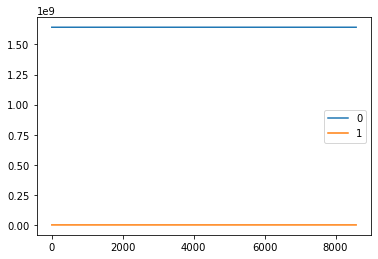

In [32]:
df.plot(kind='line')

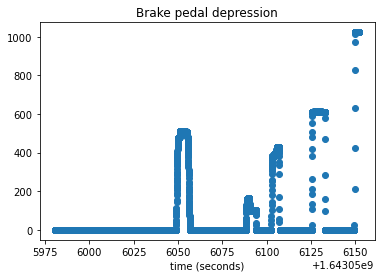

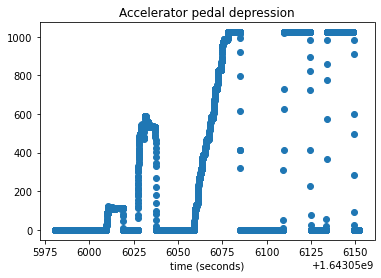

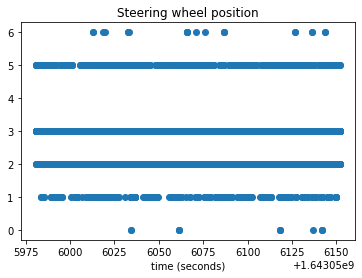

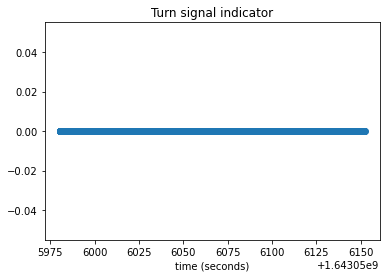

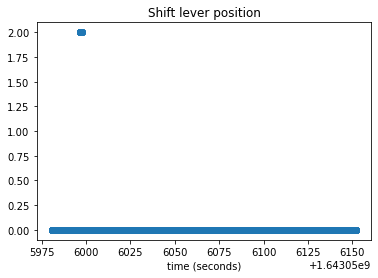

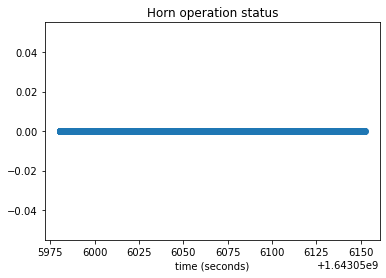

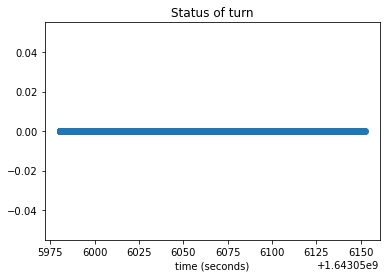

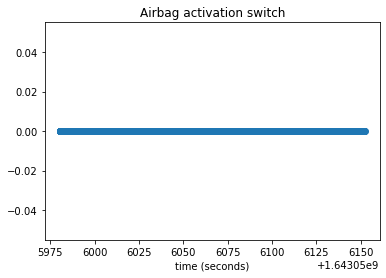

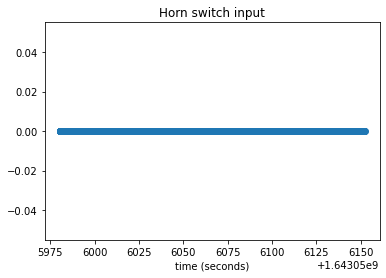

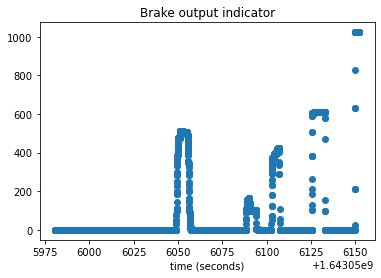

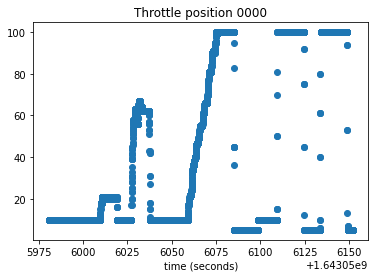

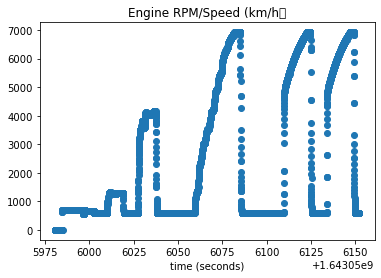

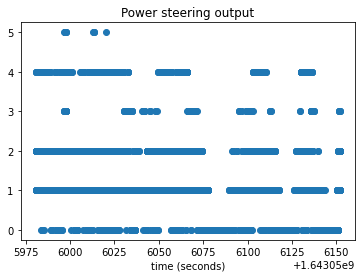

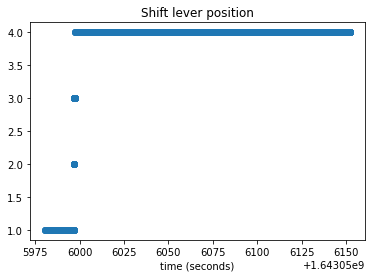

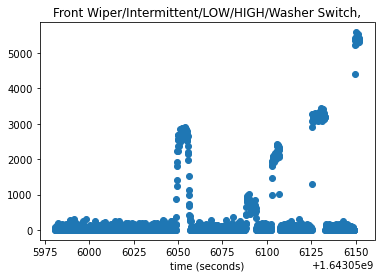

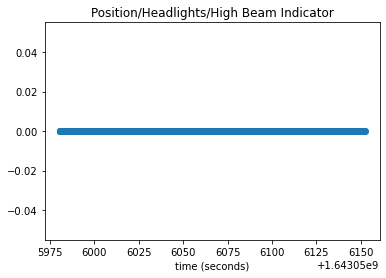

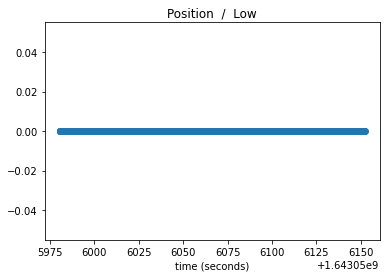

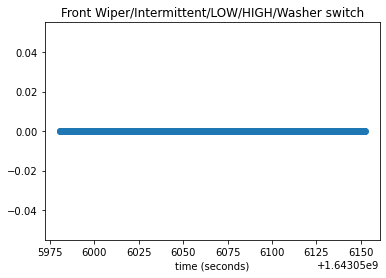

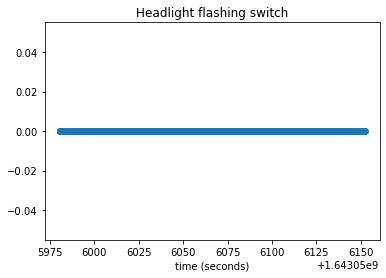

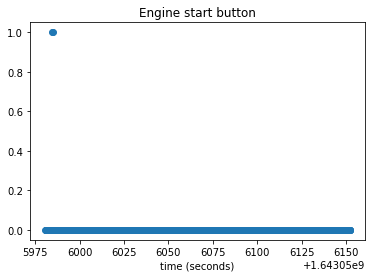

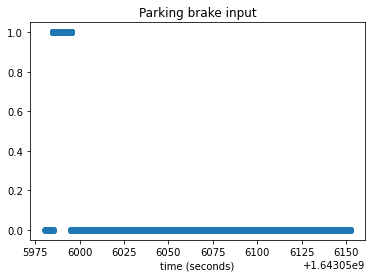

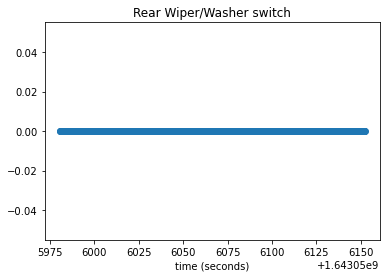

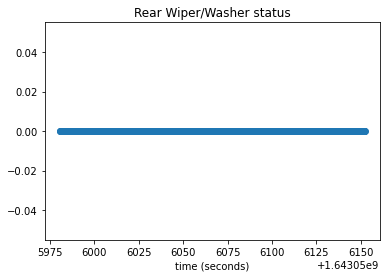

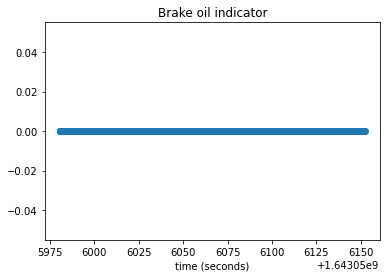

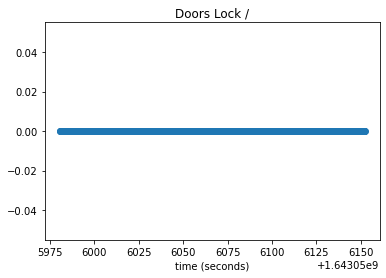

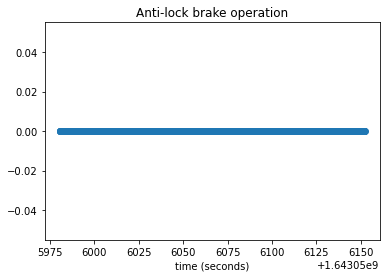

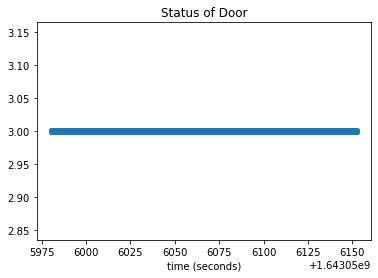

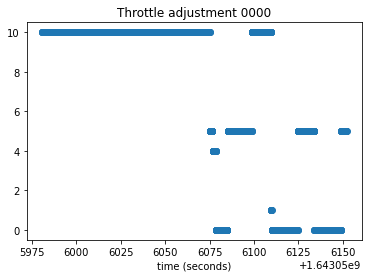

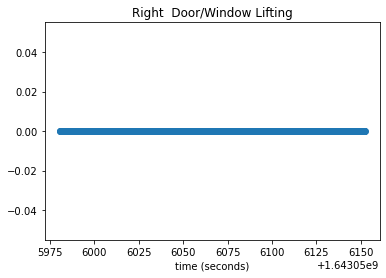

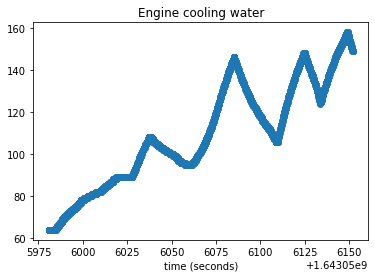

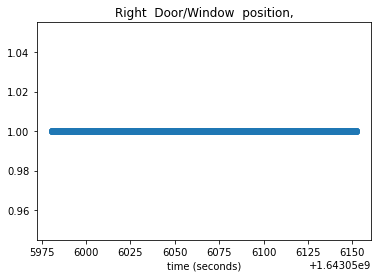

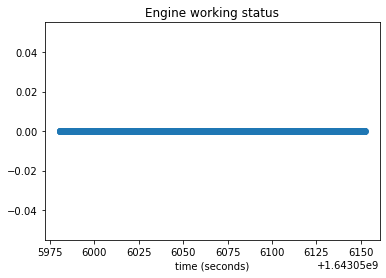

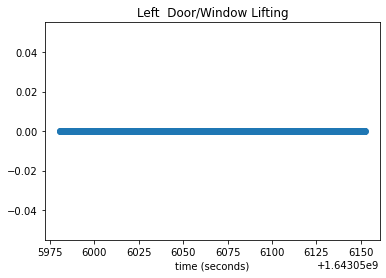

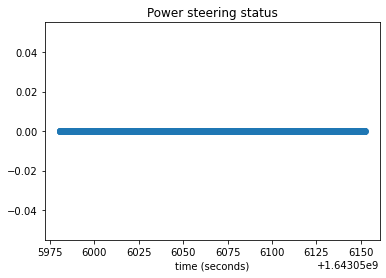

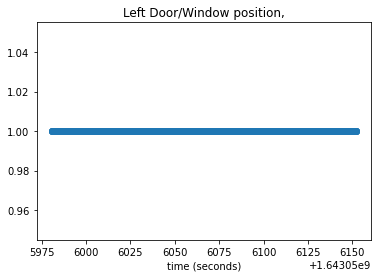

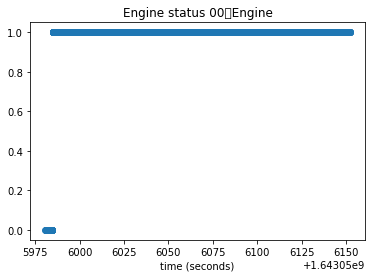

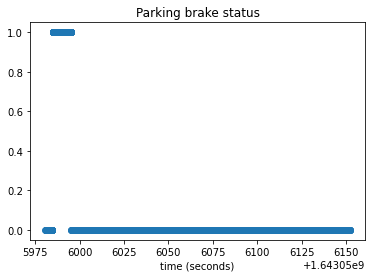

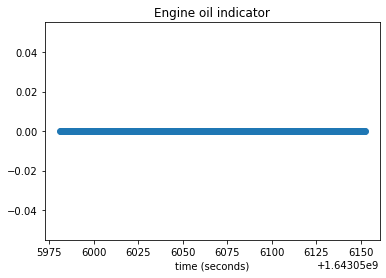

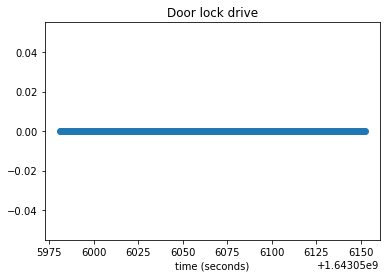

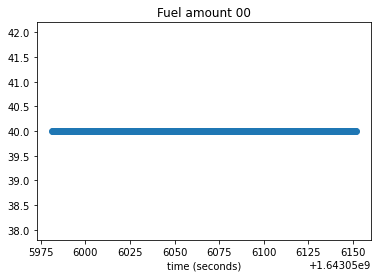

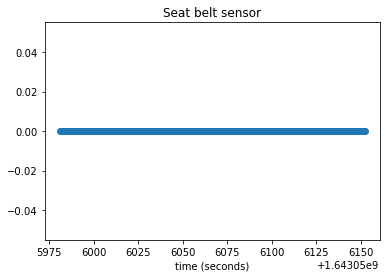

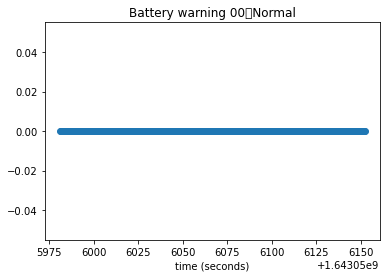

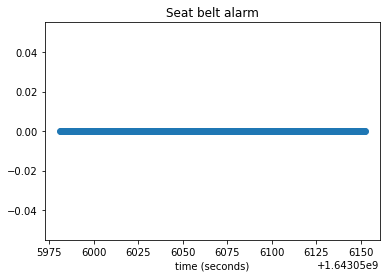

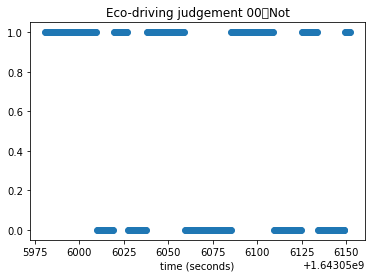

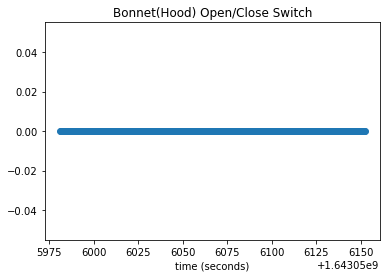

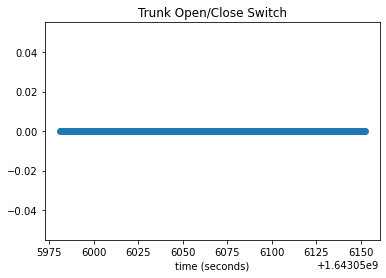

In [50]:
for can_id in graph_dict:
    title = metadata[can_id].get("description")
    title = re.search('^((?:\S+\s+){2}\S+)', title).group().strip("()")
    x, y = zip(*graph_dict[can_id])
    plt.scatter(x, y)
    plt.title(title)
    plt.xlabel("time (seconds)")
    plt.show()